In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

In [2]:
dt = pd.read_csv('IMDB Dataset.csv')
dt.sample(5)

,review,sentiment
47131,The tunes are the best aspect of this televisi...,positive
49878,"I have never read a Jacqueline Susann novel, b...",positive
39485,A few bratty kids unwittingly unleash an evil ...,negative
13115,I share the same opinion regarding Underworld ...,negative
31808,I enjoyed the cinematographic recreation of Ch...,positive


In [3]:
dt['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

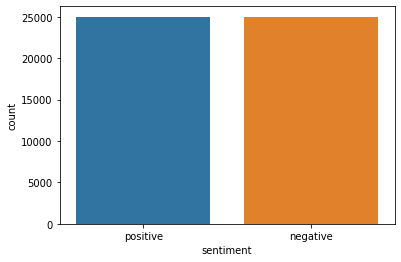

In [4]:
sns.countplot(x=dt['sentiment'])
plt.show()

In [5]:
import re
def normalize_text(text):
    text=text.lower()
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(pic\.twitter\.com/[^\s]+))','', text)
    text = re.sub('@[^\s]+','', text)
    text = re.sub('#([^\s]+)', '', text)
    text = re.sub('[:;>?<=*+()&,\-#!$%\{˜|\}\[^_\\@\]1234567890’‘]',' ', text)
    text = re.sub('[\d]','', text)
    text = text.replace(".", '')
    text = text.replace("'", '')
    text = text.replace("`", '')
    text = text.replace("'s", '')
    text = text.replace("/", ' ')
    text = text.replace("\"", ' ')
    text = text.replace("\\", '')
    #text =  re.sub(r"\b[a-z]\b", "", text)
    text=re.sub( '\s+', ' ', text).strip()
    return text

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(dt['sentiment'])
y = le.transform(dt['sentiment'])

In [7]:
le.classes_

array(['negative', 'positive'], dtype=object)

In [8]:
X = dt['review'].apply(normalize_text)

In [9]:
white_list = ['not','no']
lemmatizer = WordNetLemmatizer()

In [10]:
def rem_sws_lemmatize(text):
    text = [lemmatizer.lemmatize(words) for words in text.split() if words not in stopwords.words('english') or words in white_list]
    return text

rem_sws_lemmatize('Jumping is bad for legs')

['Jumping', 'bad', 'leg']

In [11]:
stemmer = PorterStemmer()
def rem_sws_stem(text):
    text = [stemmer.stem(words) for words in text.split() if words not in stopwords.words('english') or words in white_list]
    return ' '.join(text)

rem_sws_stem('Running is bad for nand')

'run bad nand'

In [12]:
# X = X.apply(rem_sws_stem)
# X.sample(5)

In [13]:
from tensorflow.keras.preprocessing.text import one_hot, text_to_word_sequence

In [14]:
vocab_size = 5000
#X = X.apply(text_to_word_sequence)

In [15]:
X

0        one of the other reviewers has mentioned that ...
1        a wonderful little production br br the filmin...
2        i thought this was a wonderful way to spend ti...
3        basically theres a family where a little boy j...
4        petter matteis love in the time of money is a ...
                               ...                        
49995    i thought this movie did a down right good job...
49996    bad plot bad dialogue bad acting idiotic direc...
49997    i am a catholic taught in parochial elementary...
49998    im going to have to disagree with the previous...
49999    no one expects the star trek movies to be high...
Name: review, Length: 50000, dtype: object

In [16]:
def encode_to(text):
    return one_hot(text,vocab_size)


In [17]:
encoded_X = X.apply(encode_to)

In [18]:
encoded_X.sample(5)

6713     [1541, 1673, 2837, 2823, 181, 3061, 106, 4376,...
4484     [4849, 944, 1899, 1899, 409, 4816, 436, 425, 3...
49762    [4849, 302, 2925, 409, 466, 4955, 804, 4402, 1...
26408    [2639, 4849, 3839, 1858, 2648, 4638, 804, 1192...
32902    [4849, 167, 804, 1192, 1417, 425, 256, 4547, 8...
Name: review, dtype: object

In [19]:
encoded_X.shape

(50000,)

In [20]:
from keras.utils import pad_sequences
max_len = 100
x_train = pad_sequences(encoded_X,padding='post',maxlen=max_len)

In [21]:
x_train.shape

(50000, 100)

In [22]:
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.models import Sequential

In [23]:
lstm = Sequential()
lstm.add(Embedding(vocab_size,90,input_length=max_len))
lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 90)           450000    
                                                                 
Total params: 450,000
Trainable params: 450,000
Non-trainable params: 0
_________________________________________________________________


In [24]:
lstm.add(LSTM(150,return_sequences=True))
lstm.add(LSTM(75,return_sequences=True))
lstm.add(LSTM(15,return_sequences=False))
lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 90)           450000    
                                                                 
 lstm (LSTM)                 (None, 100, 150)          144600    
                                                                 
 lstm_1 (LSTM)               (None, 100, 75)           67800     
                                                                 
 lstm_2 (LSTM)               (None, 15)                5460      
                                                                 
Total params: 667,860
Trainable params: 667,860
Non-trainable params: 0
_________________________________________________________________


In [25]:
lstm.add(Dense(60,activation='relu'))
lstm.add(Dropout(0.2))
lstm.add(Dense(30,activation='relu'))
lstm.add(Dense(2,activation='softmax'))
lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 90)           450000    
                                                                 
 lstm (LSTM)                 (None, 100, 150)          144600    
                                                                 
 lstm_1 (LSTM)               (None, 100, 75)           67800     
                                                                 
 lstm_2 (LSTM)               (None, 15)                5460      
                                                                 
 dense (Dense)               (None, 60)                960       
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense_1 (Dense)             (None, 30)                1

In [26]:
lstm.compile(optimizer='sgd',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [27]:
lstm.fit(x_train,y,epochs=3,batch_size=1000,validation_split=0.2)

Epoch 1/3
40/40 [==============================] - 130s 3s/step - loss: 0.6932 - accuracy: 0.4940 - val_loss: 0.6931 - val_accuracy: 0.5062
Epoch 2/3
40/40 [==============================] - 131s 3s/step - loss: 0.6931 - accuracy: 0.5029 - val_loss: 0.6931 - val_accuracy: 0.5117
Epoch 3/3
40/40 [==============================] - 145s 4s/step - loss: 0.6931 - accuracy: 0.5087 - val_loss: 0.6931 - val_accuracy: 0.5080
